In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from tqdm import tqdm
import os

In [154]:
def create_cnn_model(image_shape):
    input_img = Input(shape=image_shape)  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=image_shape)(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    encoder = Model(input_img, encoded)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
    
    return (autoencoder, encoder)

In [110]:
def create_den_model(image_shape):
    input_img = Input(shape=(image_shape, ))
    encoded = Dense(512, activation='relu')(input_img)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)

    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(image_shape, activation='sigmoid')(decoded)
    
    encoder = Model(input_img, encoded)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.summary()
    autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
    
    return (autoencoder, encoder)

In [30]:
def load_data(path='data', w=20):
    data = []
    files = []
    for file in tqdm(os.listdir(path)):
        if '.jpg' in file:
            files.append(file)
            img_cv = cv2.imread(os.path.join(path, file))
            img = img_cv[:, :, ::-1]
            W = img.shape[0] // w
            H = img.shape[1] // w
            for i in range(W):
                for j in range(H):
                    data.append(img[w * i: w * (i + 1), w * j: w * (j + 1), :])
    return np.array(data).astype('float32') / 255., files

In [45]:
all_data, files = load_data()

100%|██████████| 480/480 [00:00<00:00, 1164.79it/s]


In [84]:
all_data.shape

(48000, 20, 20, 3)

# CNN Autoencoder

In [85]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_data, test_size=0.2)

In [156]:
autoencoder, encoder = create_cnn_model((20, 20, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 8)           1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 8)           0         
__________

In [112]:
autoencoder.fit(X_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, y_test))

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 10s 271us/step - loss: 0.0130 - val_loss: 0.0085
Epoch 2/50
38400/38400 [==============================] - 11s 278us/step - loss: 0.0074 - val_loss: 0.0068
Epoch 3/50
38400/38400 [==============================] - 11s 286us/step - loss: 0.0066 - val_loss: 0.0064
Epoch 4/50
38400/38400 [==============================] - 12s 317us/step - loss: 0.0061 - val_loss: 0.0058
Epoch 5/50
38400/38400 [==============================] - 12s 310us/step - loss: 0.0056 - val_loss: 0.0056
Epoch 6/50
38400/38400 [==============================] - 12s 322us/step - loss: 0.0054 - val_loss: 0.0058
Epoch 7/50
38400/38400 [==============================] - 13s 326us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 8/50
38400/38400 [==============================] - 13s 339us/step - loss: 0.0050 - val_loss: 0.0051
Epoch 9/50
38400/38400 [==============================] - 12s 324us/step - loss: 0.0048 - val_l

In [113]:
autoencoder.save('autoencoder_cnn.h5')
encoder.save('encoder_cnn.h5')

In [114]:
all_data_encoder = encoder.predict(all_data)

In [144]:
kmean = KMeans(n_clusters=3, random_state=0)
y_pred = kmean.fit_predict(all_data_encoder.reshape((48000, 72)))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [148]:
y_pred_1 = y_pred.reshape((480, 10, 10))

In [142]:
def add_overlay(img, w=20, index=(0, 0), label=0):
    alpha = 0.2
    color = (0, 0, 255)
    if label==1:
        color = (0, 255, 0)
    elif label == 2:
        color = (255, 0, 0)
    elif label == 3:
        color = (255, 255, 0)
    overlay = img.copy()
    output = img.copy()
    cv2.rectangle(overlay, (index[0] * 20, index[1] * 20), (index[0] * 20 + 20, index[1] * 20 + 20), color, -1)
    
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
    
    return output

def add_overlay_img(img, overlay):
    img_1 = img.copy()
    for i in range(10):
        for j in range(10):
            img_1 = add_overlay(img_1, index=(j, i), label=overlay[i, j])
                
    return img_1

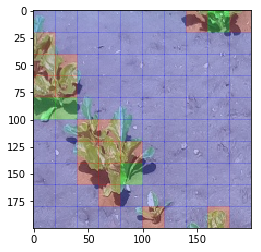

In [157]:
img_cv = cv2.imread('data/' + files[0])
img = img_cv[:, :, ::-1]

img_1 = add_overlay_img(img, y_pred_1[0])
plt.imshow(img_1)

In [151]:
data_path = 'data'
result_path = 'results_autoencoder_cnn'

for i in tqdm(range(len(files))):
    img_cv = cv2.imread(os.path.join(data_path, files[i]))
    img = img_cv[:, :, ::-1]
    
    result = add_overlay_img(img, y_pred_1[i])
    cv2.imwrite(os.path.join(result_path, files[i]), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    

100%|██████████| 480/480 [00:04<00:00, 102.16it/s]


# ANN Autoencoder

In [158]:
X_train, X_test, y_train, y_test = train_test_split(all_data.reshape((48000, 1200)), all_data.reshape((48000, 1200)), test_size=0.2)

In [160]:
autoencoder, encoder = create_den_model(1200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1200)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               614912    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 1200)              615600    
Total para

In [161]:
autoencoder.fit(X_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, y_test))

Train on 38400 samples, validate on 9600 samples
Epoch 1/50
38400/38400 [==============================] - 8s 219us/step - loss: 0.0132 - val_loss: 0.0081
Epoch 2/50
38400/38400 [==============================] - 8s 209us/step - loss: 0.0073 - val_loss: 0.0068
Epoch 3/50
38400/38400 [==============================] - 8s 211us/step - loss: 0.0064 - val_loss: 0.0061
Epoch 4/50
38400/38400 [==============================] - 9s 222us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 5/50
38400/38400 [==============================] - 9s 230us/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/50
38400/38400 [==============================] - 10s 251us/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/50
38400/38400 [==============================] - 10s 249us/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/50
38400/38400 [==============================] - 9s 246us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/50
38400/38400 [==============================] - 10s 251us/step - loss: 0.0048 - val_loss: 0

In [162]:
all_data_encoder = encoder.predict(all_data.reshape((48000, 1200)))

In [163]:
kmean = KMeans(n_clusters=3, random_state=0)
y_pred = kmean.fit_predict(all_data_encoder)

In [164]:
y_pred_1 = y_pred.reshape((480, 10, 10))

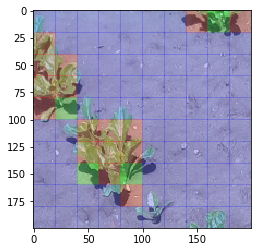

In [165]:
img_cv = cv2.imread('data/' + files[0])
img = img_cv[:, :, ::-1]

img_1 = add_overlay_img(img, y_pred_1[0])
plt.imshow(img_1)

In [167]:
data_path = 'data'
result_path = 'results_autoencoder_ann'

for i in tqdm(range(len(files))):
    img_cv = cv2.imread(os.path.join(data_path, files[i]))
    img = img_cv[:, :, ::-1]
    
    result = add_overlay_img(img, y_pred_1[i])
    cv2.imwrite(os.path.join(result_path, files[i]), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

100%|██████████| 480/480 [00:03<00:00, 120.88it/s]
